In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import cv2
import pickle as pkl
import PIL
import numpy as np
import pandas as pd
from copy import deepcopy
import time
import sys
from scipy.spatial.transform import Rotation as R

import matplotlib as mpl ; mpl.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib.pyplot import GridSpec

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
sys.path.append("/scratch/abhijatb/Bosch22")
from dreyevr_parser.parser import parse_file
from typing import Dict, List, Any
from utils import (
    check_for_periph_data,
    convert_to_df,
    split_along_subgroup,
    get_good_idxs,
)
from visualizer import plot_versus
from parser_utils import GetGazeDeviationFromHead
from ibmmpy.src.ibmmpy.ibmm import EyeClassifier

from dreyevr_attnmap_utils import *
from dreyevr_viz.lbc_data_utils import get_data

In [4]:
dataset_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/")
route_data_path = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_brady32")
aux_hitpts_root = Path('/scratch/abhijatb/Bosch22/carla.harp_p13bd/Dist/CARLA_Shipping_0.9.12-211-ga7c19cced-dirty/LinuxNoEditor/CarlaUE4/FocusInfoOuts')
aux_hitpt_filename = str(route_data_path.stem.strip("exp_"))
aux_hitpt_file = aux_hitpts_root / Path(aux_hitpt_filename + ".txt")

dreyevr_recording_txt_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings/RecordingTxts/pre-newCA/")
movie_save_dir = "/scratch/bpardhi/visualize_dreyevr_agent_saliency/gaze_outputs/"
attn_map_save_dir = "/scratch/bpardhi/visualize_dreyevr_agent_saliency/attn_map_outputs/"

In [5]:
# read a recording
route_data_path = Path('/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11')
# load the dreyevr data from recording txt
participant_name_route = route_data_path.stem.split('_')[-1]
participant_name = participant_name_route[:-2]
recordingtxt_path = dreyevr_recording_txt_root / participant_name / (participant_name_route + ".txt")
df_new = load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path)

dreyevr_data_path =  route_data_path / "dreyevr_data"

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.356s


In [6]:
# read focus hitpts from the aux replay outputs and parse them 
# (older recordings have focus hitpt computed on channel that blocks invisble actors which is undesirable)

apply_focusinfohitpt_correction=True

## Attention Map movie generation

In [7]:
from attentionMapCreator import *

In [8]:
route_data_paths = list(Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/").glob("*/"))
route_data_paths.insert(0, Path('/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11'))
glob_radius = 20
glob_sigma = 1
glob_alpha = 0.3
image_blur = True
glob_blur = False
color_ = False
if glob_blur and image_blur == False:
    type_ = "_image_color" if color_  else "_image_bw"
elif image_blur and glob_blur:
    type_ = "_gaze_color" if color_  else "_gaze_bw" 
if image_blur and glob_blur == False:
    type_ = "_gaze_clear"
    
from tqdm import tqdm
for route_data_path in tqdm(route_data_paths):
    try:
        # load the dreyevr data from recording txt
        participant_name_route = route_data_path.stem.split('_')[-1]
        participant_name = participant_name_route[:-2]
        recordingtxt_path = dreyevr_recording_txt_root / participant_name / (participant_name_route + ".txt")
        df_new = load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path)

        aux_hitpt_filename = str(route_data_path.stem.strip("exp_"))
        aux_hitpt_file = aux_hitpts_root / Path(aux_hitpt_filename + ".txt")
        if apply_focusinfohitpt_correction:
            FocusInfoHitPts_fixed = loadFocusInfoCorrected(aux_hitpt_file, len(df_new))
            df_new = df_new.assign(FocusInfo_HitPoint=FocusInfoHitPts_fixed)

        dreyevr_data_path =  route_data_path / "dreyevr_data"

        overlay_rad=1
        # write a movie with gaze overlay
        movie_title = participant_name_route + "_" + str(glob_radius) + type_ + ".mkv"
        if Path(movie_save_dir+movie_title).exists():
            continue

        resolution=200
        FFMpegWriter = manimation.writers['ffmpeg']
        metadata = dict(title=movie_title, artist='ajdroid', comment='dreyevrLBC-gaze-to-cam')
        writer = FFMpegWriter(fps=2, metadata=metadata)

        final_datapt_idx = int(sorted(list((route_data_path/'rgb').glob('*.png')))[-1].stem)
        datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png
        prog = '' ; total_frames = datapt_idcs[-1]
        start = time.time()

        fig = plt.figure(dpi=resolution)
        gaze_memory_window=50 # this is number of ticks, x/20 is num seconds
        gaze_frames_per_img = 10
        gaze_history = 0

        with writer.saving(fig, movie_save_dir+movie_title, resolution):
            # for tick in range(1*10 + gaze_memory_window, (total_frames-3)*10, 10):
            for tick in range(gaze_frames_per_img + gaze_history, (total_frames)*10, 10):
                vehicle_transform = None
                tickbyten = tick//10
                tick_data = get_data(route_data_path, tickbyten)

                rgb_img = deepcopy(tick_data['rgb'])
                left_img = deepcopy(tick_data['rgb_left'])
                right_img = deepcopy(tick_data['rgb_right'])

                gaze_in_cam_arr = np.zeros((gaze_memory_window, 2))
                gaze_in_cam_arr_rgt = np.zeros((gaze_memory_window, 2))
                gaze_in_cam_arr_lft = np.zeros((gaze_memory_window, 2))

                fixation_mid = []
                fixation_rgt = []
                fixation_lft = []

                for tick_mem in np.arange(tick, tick-gaze_history, -1):
                    dreyevr_data_t1 = dreyevr_data_path / ("{:04d}_{:05d}.pkl".format(tick_mem//10, tick_mem))
                    with open(dreyevr_data_t1, 'rb') as f:
                        dreyevr_data_dict = pkl.load(f)

                    tick_row_df = df_new[df_new.FrameSequence == dreyevr_data_dict['framesequence']]

                    if tick_mem==tick:
                        # if you want attention map using 3d locations rather than pixel locs, use current vehicle loc 
                        # instead of vehicle loc at the time
                        vehicle_loc = carla.Location(*(tick_row_df['VehicleLoc'].squeeze()))/100
                        vehicle_rot = carla.Rotation(*(tick_row_df['VehicleRot'].squeeze()))    
                        vehicle_transform = carla.Transform(location=vehicle_loc, rotation=vehicle_rot)

                    # need to remove the saccades
                    tick_focus_hitpt = np.array(tick_row_df.FocusInfo_HitPoint.squeeze())/100 # cm -> m
                    # is tick_focus_hitpt is empty, then continue
                    if tick_focus_hitpt.shape != (3,):
                        continue
                    gaze_in_cam_mid, gaze_in_cam_lft, gaze_in_cam_rgt  = world2pixels(tick_focus_hitpt, vehicle_transform, K)
                    gaze_in_cam_arr[tick - tick_mem] = gaze_in_cam_mid
                    gaze_in_cam_arr_rgt[tick - tick_mem] = gaze_in_cam_rgt
                    gaze_in_cam_arr_lft[tick - tick_mem] = gaze_in_cam_lft

                    # need to remove the saccades
                    if tick_row_df["label"].squeeze() == 0:
                        fixation_mid.append(gaze_in_cam_mid)
                        fixation_rgt.append(gaze_in_cam_rgt)
                        fixation_lft.append(gaze_in_cam_lft)

                fixationMidNumpy = np.array(fixation_mid).astype(int).reshape(-1, 2)
                fixationRgtNumpy = np.array(fixation_rgt).astype(int).reshape(-1, 2)
                fixationLftNumpy = np.array(fixation_lft).astype(int).reshape(-1, 2)
                rgb_img, attentionMap = draw_attention_map(fixationMidNumpy, 
                                                                rgb_img, 
                                                                alpha = glob_alpha, 
                                                                sigma=glob_sigma, 
                                                                radius=glob_radius,
                                                                image_blur=image_blur,
                                                                glob_blur=glob_blur, 
                                                                color_=color_)
                right_img, attentionMap = draw_attention_map(fixationRgtNumpy,
                                                                    right_img,
                                                                    alpha = glob_alpha,
                                                                    sigma=glob_sigma,
                                                                    radius=glob_radius,
                                                                image_blur=image_blur,
                                                                glob_blur=glob_blur, 
                                                                color_=color_)
                left_img, attentionMap = draw_attention_map(fixationLftNumpy,
                                                                left_img,
                                                                alpha = glob_alpha,
                                                                sigma=glob_sigma,
                                                                radius=glob_radius,
                                                                image_blur=image_blur,
                                                                glob_blur=glob_blur, 
                                                                color_=color_)


                img_3stack = np.hstack([left_img, rgb_img, right_img])

                plt.imshow(img_3stack)
                writer.grab_frame() ; fig.clear()

                if tick < gaze_frames_per_img + gaze_memory_window:
                    gaze_history += gaze_frames_per_img 
                else:
                    gaze_history = gaze_memory_window

                tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
                print('\ttime: {} | progress: {:.1f}%'.format(tstr, 100*tickbyten/total_frames), end='\r')
    except:
        # print the error that caused the failure
        import traceback
        print(traceback.format_exc())
        print("Failed on: ", participant_name_route)
        print("Couldn't process ", route_data_path)
        continue

  0%|          | 0/18 [00:00<?, ?it/s]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.387s


  6%|▌         | 1/18 [00:57<16:24, 57.90s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.482s


 11%|█         | 2/18 [01:48<14:49, 55.57s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/dexter32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.039s


 17%|█▋        | 3/18 [01:48<09:44, 39.00s/it]

-6430
Traceback (most recent call last):
  File "<ipython-input-8-8d9c78935f9c>", line 28, in <module>
    FocusInfoHitPts_fixed = loadFocusInfoCorrected(aux_hitpt_file, len(df_new))
  File "/scratch/bpardhi/visualize_dreyevr_agent_saliency/dreyevr_attnmap_utils.py", line 258, in loadFocusInfoCorrected
    FocusInfoHitPts = FocusInfoHitPts.repeat(list(rpt_idcs))
  File "/home/bpardhi/anaconda3/envs/dreyevr/lib/python3.8/site-packages/pandas/core/series.py", line 1389, in repeat
    new_index = self.index.repeat(repeats)
  File "/home/bpardhi/anaconda3/envs/dreyevr/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 1262, in repeat
    res_values = self._values.repeat(repeats)
ValueError: repeats may not contain negative values.

Failed on:  dexter32
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_dexter32
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.

 22%|██▏       | 4/18 [01:49<06:25, 27.52s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/dexter11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.215s


 28%|██▊       | 5/18 [02:36<07:13, 33.35s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.227s


 33%|███▎      | 6/18 [03:24<07:34, 37.89s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.418s


 39%|███▉      | 7/18 [04:24<08:08, 44.37s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/swapnil32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.279s


 44%|████▍     | 8/18 [05:14<07:41, 46.17s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/swapnil54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.291s


 50%|█████     | 9/18 [06:07<07:14, 48.25s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.454s


 56%|█████▌    | 10/18 [06:58<06:33, 49.21s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/esther54.pkl
gathered periph data in 0.000s


 61%|██████    | 11/18 [06:59<04:02, 34.58s/it]

created DReyeVR df in 0.326s
Traceback (most recent call last):
  File "<ipython-input-8-8d9c78935f9c>", line 28, in <module>
    FocusInfoHitPts_fixed = loadFocusInfoCorrected(aux_hitpt_file, len(df_new))
  File "/scratch/bpardhi/visualize_dreyevr_agent_saliency/dreyevr_attnmap_utils.py", line 231, in loadFocusInfoCorrected
    with open(aux_hitpt_file,"r") as f:
FileNotFoundError: [Errno 2] No such file or directory: '/scratch/abhijatb/Bosch22/carla.harp_p13bd/Dist/CARLA_Shipping_0.9.12-211-ga7c19cced-dirty/LinuxNoEditor/CarlaUE4/FocusInfoOuts/sther54.txt'

Failed on:  esther54
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_esther54
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/jacob54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.267s


 67%|██████▋   | 12/18 [07:51<03:59, 39.98s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/esther11.pkl
gathered periph data in 0.000s


 72%|███████▏  | 13/18 [07:52<02:20, 28.12s/it]

created DReyeVR df in 0.316s
Traceback (most recent call last):
  File "<ipython-input-8-8d9c78935f9c>", line 28, in <module>
    FocusInfoHitPts_fixed = loadFocusInfoCorrected(aux_hitpt_file, len(df_new))
  File "/scratch/bpardhi/visualize_dreyevr_agent_saliency/dreyevr_attnmap_utils.py", line 231, in loadFocusInfoCorrected
    with open(aux_hitpt_file,"r") as f:
FileNotFoundError: [Errno 2] No such file or directory: '/scratch/abhijatb/Bosch22/carla.harp_p13bd/Dist/CARLA_Shipping_0.9.12-211-ga7c19cced-dirty/LinuxNoEditor/CarlaUE4/FocusInfoOuts/sther11.txt'

Failed on:  esther11
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_esther11
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/alex54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.277s


 78%|███████▊  | 14/18 [08:42<02:18, 34.71s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/dexter54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.290s


 83%|████████▎ | 15/18 [09:30<01:55, 38.64s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.312s


 89%|████████▉ | 16/18 [10:24<01:26, 43.36s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/swapnil11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.332s


 94%|█████████▍| 17/18 [11:21<00:47, 47.53s/it]

Traceback (most recent call last):
  File "<ipython-input-8-8d9c78935f9c>", line 83, in <module>
    vehicle_loc = carla.Location(*(tick_row_df['VehicleLoc'].squeeze()))/100
Boost.Python.ArgumentError: Python argument types in
    Location.__init__(Location, list, list)
did not match C++ signature:
    __init__(_object*, carla::geom::Vector3D rhs)
    __init__(_object*, float x=0.0, float y=0.0, float z=0.0)
    __init__(_object*)

Failed on:  swapnil11
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_swapnil11
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/esther32.pkl
gathered periph data in 0.000s


100%|██████████| 18/18 [11:22<00:00, 37.92s/it]

created DReyeVR df in 0.378s
Traceback (most recent call last):
  File "<ipython-input-8-8d9c78935f9c>", line 28, in <module>
    FocusInfoHitPts_fixed = loadFocusInfoCorrected(aux_hitpt_file, len(df_new))
  File "/scratch/bpardhi/visualize_dreyevr_agent_saliency/dreyevr_attnmap_utils.py", line 231, in loadFocusInfoCorrected
    with open(aux_hitpt_file,"r") as f:
FileNotFoundError: [Errno 2] No such file or directory: '/scratch/abhijatb/Bosch22/carla.harp_p13bd/Dist/CARLA_Shipping_0.9.12-211-ga7c19cced-dirty/LinuxNoEditor/CarlaUE4/FocusInfoOuts/sther32.txt'

Failed on:  esther32
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_esther32


## Saving attention maps

In [1]:
import os
from attentionMapCreator import *
from tqdm import tqdm
from pathlib import Path
import cv2
import pickle as pkl
import PIL
import numpy as np
import pandas as pd
from copy import deepcopy
import time
import sys
from scipy.spatial.transform import Rotation as R

import matplotlib as mpl ; mpl.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib.pyplot import GridSpec

import scipy.stats as stats

apply_focusinfohitpt_correction=True

sys.path.append("/scratch/abhijatb/Bosch22")
from dreyevr_parser.parser import parse_file
from typing import Dict, List, Any
from utils import (
    check_for_periph_data,
    convert_to_df,
    split_along_subgroup,
    get_good_idxs,
)
from visualizer import plot_versus
from parser_utils import GetGazeDeviationFromHead
from ibmmpy.src.ibmmpy.ibmm import EyeClassifier

from dreyevr_attnmap_utils import *
from dreyevr_viz.lbc_data_utils import get_data

dataset_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/")
aux_hitpts_root = Path('/scratch/abhijatb/Bosch22/carla.harp_p13bd/Dist/CARLA_Shipping_0.9.12-211-ga7c19cced-dirty/LinuxNoEditor/CarlaUE4/FocusInfoOuts')
route_data_paths = list(Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/").glob("*/"))
# route_data_paths.insert(0, Path('/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11'))
dreyevr_recording_txt_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings/RecordingTxts/pre-newCA/")
attn_map_save_dir = "/scratch/bpardhi/visualize_dreyevr_agent_saliency/attn_map_test/"

glob_radius = 20
glob_sigma = 1
glob_alpha = 0.3
image_blur = True
glob_blur = False
color_ = False
threshold = 0
if glob_blur and image_blur == False:
    type_ = "_image_color" if color_  else "_image_bw"
elif image_blur and glob_blur:
    type_ = "_gaze_color" if color_  else "_gaze_bw" 
if image_blur and glob_blur == False:
    type_ = "_gaze_clear"


for route_data_path in tqdm(route_data_paths):
    try:
        # load the dreyevr data from recording txt
        participant_name_route = route_data_path.stem.split('_')[-1]
        participant_name = participant_name_route[:-2]
        recordingtxt_path = dreyevr_recording_txt_root / participant_name / (participant_name_route + ".txt")
        df_new = load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path)

        aux_hitpt_filename = str(route_data_path.stem.strip("exp_"))
        aux_hitpt_file = aux_hitpts_root / Path(aux_hitpt_filename + ".txt")
        if apply_focusinfohitpt_correction:
            FocusInfoHitPts_fixed = loadFocusInfoCorrected(aux_hitpt_file, len(df_new))
            df_new = df_new.assign(FocusInfo_HitPoint=FocusInfoHitPts_fixed)

        dreyevr_data_path =  route_data_path / "dreyevr_data"

        overlay_rad=1
        # write a movie with gaze overlay
        folderName = attn_map_save_dir + participant_name_route + "_radius_" + str(glob_radius) + type_ 
        if not os.path.exists(folderName):
            os.makedirs(folderName)

        if not os.path.exists(folderName + "/midAttnMap"):
            os.makedirs(folderName + "/midAttnMap")

        if not os.path.exists(folderName + "/leftAttnMap"):
            os.makedirs(folderName + "/leftAttnMap")

        if not os.path.exists(folderName + "/rightAttnMap"):
            os.makedirs(folderName + "/rightAttnMap")

        final_datapt_idx = int(sorted(list((route_data_path/'rgb').glob('*.png')))[-1].stem)
        datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png
        prog = '' ; total_frames = datapt_idcs[-1]
        start = time.time()

        gaze_memory_window=50 # this is number of ticks, x/20 is num seconds
        gaze_frames_per_img = 10
        gaze_history = 0
        for tick in range(gaze_frames_per_img + gaze_history, (total_frames)*10, 10):
            vehicle_transform = None
            tickbyten = tick//10
            tick_data = get_data(route_data_path, tickbyten)

            rgb_img = deepcopy(tick_data['rgb'])
            left_img = deepcopy(tick_data['rgb_left'])
            right_img = deepcopy(tick_data['rgb_right'])

            gaze_in_cam_arr = np.zeros((gaze_memory_window, 2))
            gaze_in_cam_arr_rgt = np.zeros((gaze_memory_window, 2))
            gaze_in_cam_arr_lft = np.zeros((gaze_memory_window, 2))

            fixation_mid = []
            fixation_rgt = []
            fixation_lft = []
            # print("\n\n tick: ", tick, "total_frames: ", total_frames) 
            for tick_mem in np.arange(tick, tick-gaze_history, -1):
                dreyevr_data_t1 = dreyevr_data_path / ("{:04d}_{:05d}.pkl".format(tick_mem//10, tick_mem))
                with open(dreyevr_data_t1, 'rb') as f:
                    dreyevr_data_dict = pkl.load(f)

                tick_row_df = df_new[df_new.FrameSequence == dreyevr_data_dict['framesequence']]
                fixation_rgb = []
                fixation_left = []
                fixation_right = []
                if tick_mem==tick:
                    # if you want attention map using 3d locations rather than pixel locs, use current vehicle loc 
                    # instead of vehicle loc at the time
                    vehicle_loc = carla.Location(*(tick_row_df['VehicleLoc'].squeeze()))/100
                    vehicle_rot = carla.Rotation(*(tick_row_df['VehicleRot'].squeeze()))    
                    vehicle_transform = carla.Transform(location=vehicle_loc, rotation=vehicle_rot)

                tick_focus_hitpt = np.array(tick_row_df.FocusInfo_HitPoint.squeeze())/100 # cm -> m

                # is tick_focus_hitpt is empty, then continue
                if len(tick_focus_hitpt) == 0:
                    continue

                gaze_in_cam_mid, gaze_in_cam_lft, gaze_in_cam_rgt  = world2pixels(tick_focus_hitpt, vehicle_transform, K)
                gaze_in_cam_arr[tick - tick_mem] = gaze_in_cam_mid
                gaze_in_cam_arr_rgt[tick - tick_mem] = gaze_in_cam_rgt
                gaze_in_cam_arr_lft[tick - tick_mem] = gaze_in_cam_lft

                # need to remove the saccades
                if tick_row_df["label"].squeeze() == 0:
                    fixation_mid.append(gaze_in_cam_mid)
                    fixation_rgt.append(gaze_in_cam_rgt)
                    fixation_lft.append(gaze_in_cam_lft)

            fixationMidNumpy = np.array(fixation_mid).astype(int).reshape(-1, 2)
            fixationRgtNumpy = np.array(fixation_rgt).astype(int).reshape(-1, 2)
            fixationLftNumpy = np.array(fixation_lft).astype(int).reshape(-1, 2)

            rgb_img, attentionMapMid = draw_attention_map(fixationMidNumpy, 
                                                            rgb_img, 
                                                            alpha = glob_alpha, 
                                                            sigma=glob_sigma, 
                                                            radius=glob_radius,
                                                            image_blur=image_blur,
                                                            glob_blur=glob_blur, 
                                                            color_=color_,
                                                            threshold = threshold)
            right_img, attentionMapRight = draw_attention_map(fixationRgtNumpy,
                                                                right_img,
                                                                alpha = glob_alpha,
                                                                sigma=glob_sigma,
                                                                radius=glob_radius,
                                                            image_blur=image_blur,
                                                            glob_blur=glob_blur, 
                                                            color_=color_,
                                                            threshold = threshold)
            left_img, attentionMapLeft = draw_attention_map(fixationLftNumpy,
                                                            left_img,
                                                            alpha = glob_alpha,
                                                            sigma=glob_sigma,
                                                            radius=glob_radius,
                                                            image_blur=image_blur,
                                                            glob_blur=glob_blur, 
                                                            color_=color_,
                                                            threshold = threshold)

            # save the attention maps in form of binary numpy arrays
            np.save(folderName + "/midAttnMap/" + '{:04d}.npy'.format(tickbyten), attentionMapMid)
            np.save(folderName + "/rightAttnMap/" + '{:04d}.npy'.format(tickbyten), attentionMapRight)
            np.save(folderName + "/leftAttnMap/" + '{:04d}.npy'.format(tickbyten), attentionMapLeft)

            tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
            print('\ttime: {} | progress: {:.1f}%'.format(tstr, 100*tickbyten/total_frames), end='\r')
            if tick < gaze_frames_per_img + gaze_memory_window:
                gaze_history += gaze_frames_per_img 
            else:
                gaze_history = gaze_memory_window
            
    except:
        print("Couldn't process ", route_data_path)
        continue
    # break

  0%|          | 0/17 [00:00<?, ?it/s]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.380s


  6%|▌         | 1/17 [00:29<07:46, 29.17s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/dexter32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.032s


 12%|█▏        | 2/17 [00:29<05:07, 20.51s/it]

-6430
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_dexter32
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.413s


 18%|█▊        | 3/17 [01:04<05:48, 24.91s/it]

Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/dexter11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.430s


 24%|██▎       | 4/17 [01:32<05:35, 25.77s/it]

Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_dexter11
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.271s


 29%|██▉       | 5/17 [02:01<05:21, 26.78s/it]

Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab54
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.284s


 35%|███▌      | 6/17 [02:37<05:23, 29.39s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/swapnil32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.267s


 41%|████      | 7/17 [03:06<04:53, 29.38s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/swapnil54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.415s


 47%|████▋     | 8/17 [03:38<04:31, 30.15s/it]

Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_swapnil54
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.259s


 53%|█████▎    | 9/17 [04:07<03:58, 29.81s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/esther54.pkl
gathered periph data in 0.000s


 59%|█████▉    | 10/17 [04:07<02:26, 20.99s/it]

created DReyeVR df in 0.319s
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_esther54
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/jacob54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.276s


 65%|██████▍   | 11/17 [04:38<02:22, 23.80s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/esther11.pkl
gathered periph data in 0.000s


 71%|███████   | 12/17 [04:38<01:23, 16.75s/it]

created DReyeVR df in 0.193s
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_esther11
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/alex54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.288s


 76%|███████▋  | 13/17 [05:08<01:23, 20.77s/it]

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/dexter54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.302s


 82%|████████▏ | 14/17 [05:35<01:08, 22.73s/it]

Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_dexter54
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.262s


 88%|████████▊ | 15/17 [05:37<00:32, 16.40s/it]

Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab32
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/swapnil11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.437s


 94%|█████████▍| 16/17 [06:11<00:21, 21.70s/it]

Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_swapnil11
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/esther32.pkl
gathered periph data in 0.000s


100%|██████████| 17/17 [06:11<00:00, 21.88s/it]

created DReyeVR df in 0.299s
Couldn't process  /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_esther32


## Test funtion

In [10]:
import os
from attentionMapCreator import draw_attention_map
from tqdm import tqdm
from pathlib import Path
import cv2
import pickle as pkl
import PIL
import numpy as np
import pandas as pd
from copy import deepcopy
import time
import sys
import scipy.stats as stats
sys.path.append("/scratch/abhijatb/Bosch22")
from dreyevr_parser.parser import parse_file
from typing import Dict, List, Any
from utils import (
    check_for_periph_data,
    convert_to_df,
    split_along_subgroup,
    get_good_idxs,
)
from visualizer import plot_versus
from parser_utils import GetGazeDeviationFromHead
from ibmmpy.src.ibmmpy.ibmm import EyeClassifier
from dreyevr_attnmap_utils import *
from dreyevr_viz.lbc_data_utils import get_data
import matplotlib as mpl

dataset_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/")
aux_hitpts_root = Path('/scratch/abhijatb/Bosch22/carla.harp_p13bd/Dist/CARLA_Shipping_0.9.12-211-ga7c19cced-dirty/LinuxNoEditor/CarlaUE4/FocusInfoOuts')
route_data_paths = list(Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/").glob("*/"))
# route_data_paths.insert(0, Path('/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11'))
dreyevr_recording_txt_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings/RecordingTxts/pre-newCA/")

'''
A function that take in the route_data_path, radius, sigma, threshold, and gaze_memory_window 
It returns the 20 consecutive frames of the route images with the attention maps drawn on them
dataPathIdx:
0: exp_brady32 
1: exp_dexter32 
2: exp_tab11 
3: exp_dexter11 
4: exp_tab54 
5: exp_brady11 
6: exp_swapnil32 
7: exp_swapnil54 
8: exp_brady54 
9: exp_esther54 
10: exp_jacob54 
11: exp_esther11 
12: exp_alex54 
13: exp_dexter54 
14: exp_tab32 
15: exp_swapnil11 
16: exp_esther3
''' 
def debugAttentionMapOverlay(radius= 10, 
                                                  sigma= 2, 
                                                  gaze_memory_window = 50,
                                                  threshold = 0,
                                                  dataPathIdx= 0, 
                                                  threshold2 = 0.003):
    glob_radius = radius
    glob_sigma = sigma
    glob_alpha = 0.5
    image_blur = False
    glob_blur = True
    color_ = True
    route_data_path = route_data_paths[dataPathIdx]
    participant_name_route = route_data_path.stem.split('_')[-1]
    participant_name = participant_name_route[:-2]
    recordingtxt_path = dreyevr_recording_txt_root / participant_name / (participant_name_route + ".txt")
    df_new = load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path)
    aux_hitpt_filename = str(route_data_path.stem.strip("exp_"))
    aux_hitpt_file = aux_hitpts_root / Path(aux_hitpt_filename + ".txt")
    apply_focusinfohitpt_correction = True
    if apply_focusinfohitpt_correction:
        FocusInfoHitPts_fixed = loadFocusInfoCorrected(aux_hitpt_file, len(df_new))
        df_new = df_new.assign(FocusInfo_HitPoint=FocusInfoHitPts_fixed)

    dreyevr_data_path =  route_data_path / "dreyevr_data"
    final_datapt_idx = int(sorted(list((route_data_path/'rgb').glob('*.png')))[-1].stem)
    datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png
    prog = '' ; total_frames = datapt_idcs[-1]
    # if final_datapt_idx > 100:
    #     final_datapt_idx = 100
    # else:
    #     print("\n  not enough frames to show")
    #     return

    gaze_frames_per_img = 10
    gaze_history = 0
    # an array to store maps
    maps = []
    images = []

    from tqdm import tqdm
    for tick in tqdm(range(gaze_frames_per_img + gaze_history, (total_frames)*10, 10)):
        vehicle_transform = None
        tickbyten = tick//10
        tick_data = get_data(route_data_path, tickbyten)

        rgb_img = deepcopy(tick_data['rgb'])
        left_img = deepcopy(tick_data['rgb_left'])
        right_img = deepcopy(tick_data['rgb_right'])

        gaze_in_cam_arr = np.zeros((gaze_memory_window, 2))
        gaze_in_cam_arr_rgt = np.zeros((gaze_memory_window, 2))
        gaze_in_cam_arr_lft = np.zeros((gaze_memory_window, 2))

        fixation_mid = []
        fixation_rgt = []
        fixation_lft = []

        for tick_mem in np.arange(tick, tick-gaze_history, -1):
            dreyevr_data_t1 = dreyevr_data_path / ("{:04d}_{:05d}.pkl".format(tick_mem//10, tick_mem))
            with open(dreyevr_data_t1, 'rb') as f:
                dreyevr_data_dict = pkl.load(f)

            tick_row_df = df_new[df_new.FrameSequence == dreyevr_data_dict['framesequence']]

            if tick_mem==tick:
                # if you want attention map using 3d locations rather than pixel locs, use current vehicle loc 
                # instead of vehicle loc at the time
                vehicle_loc = carla.Location(*(tick_row_df['VehicleLoc'].squeeze()))/100
                vehicle_rot = carla.Rotation(*(tick_row_df['VehicleRot'].squeeze()))    
                vehicle_transform = carla.Transform(location=vehicle_loc, rotation=vehicle_rot)

            tick_focus_hitpt = np.array(tick_row_df.FocusInfo_HitPoint.squeeze())/100 # cm -> m

            # is tick_focus_hitpt is empty, then continue
            if tick_focus_hitpt.shape != (3,):
                continue

            gaze_in_cam_mid, gaze_in_cam_lft, gaze_in_cam_rgt  = world2pixels(tick_focus_hitpt, vehicle_transform, K)
            gaze_in_cam_arr[tick - tick_mem] = gaze_in_cam_mid
            gaze_in_cam_arr_rgt[tick - tick_mem] = gaze_in_cam_rgt
            gaze_in_cam_arr_lft[tick - tick_mem] = gaze_in_cam_lft

            # need to remove the saccades
            if tick_row_df["label"].squeeze() == 0:
                fixation_mid.append(gaze_in_cam_mid)
                fixation_rgt.append(gaze_in_cam_rgt)
                fixation_lft.append(gaze_in_cam_lft)

        fixationMidNumpy = np.array(fixation_mid).astype(int).reshape(-1, 2)
        fixationRgtNumpy = np.array(fixation_rgt).astype(int).reshape(-1, 2)
        fixationLftNumpy = np.array(fixation_lft).astype(int).reshape(-1, 2)
        images.append([np.array(left_img), np.array(rgb_img), np.array(right_img)])

        rgb_img, attentionMapMid = draw_attention_map(fixationMidNumpy, 
                                                                                        rgb_img, 
                                                                                        alpha = glob_alpha, 
                                                                                        sigma=glob_sigma, 
                                                                                        radius=glob_radius,
                                                                                        image_blur=image_blur,
                                                                                        glob_blur=glob_blur, 
                                                                                        color_=color_)
        right_img, attentionMapRight = draw_attention_map(fixationRgtNumpy,
                                                                                            right_img,
                                                                                            alpha = glob_alpha,
                                                                                            sigma=glob_sigma,
                                                                                            radius=glob_radius,
                                                                                            image_blur=image_blur,
                                                                                            glob_blur=glob_blur, 
                                                                                            color_=color_)
        left_img, attentionMapLeft = draw_attention_map(fixationLftNumpy,
                                                                                        left_img,
                                                                                        alpha = glob_alpha,
                                                                                        sigma=glob_sigma,
                                                                                        radius=glob_radius,
                                                                                        image_blur=image_blur,
                                                                                        glob_blur=glob_blur, 
                                                                                        color_=color_)
        # add the maps
        maps.append([attentionMapLeft, attentionMapMid, attentionMapRight])
        if tick < gaze_frames_per_img + gaze_memory_window:
            gaze_history += gaze_frames_per_img 
        else:
            gaze_history = gaze_memory_window

    upperLim = threshold + threshold2
    # create a figure with 20 rows and 3 columns (set the size automatically)
    fig, axs = plt.subplots(20, 3, figsize=(50, 180))
    # plot the images with the attention maps on top
    print("\n\nnumber of images: ", len(images))
    for i in range(50, 250, 10):
        side = "left"
        for j in range(3):
            img = images[i][j]
            attnMap = maps[i][j]
            attnMap[attnMap > upperLim] = upperLim
            attentionMapCopy = attnMap.copy()
            attentionMapCopy = attentionMapCopy / attentionMapCopy.max()
            heatMap = plt.cm.jet(attentionMapCopy)[:, :, :3]
            heatMap = (heatMap * 255).astype(np.uint8)
            # plot the heatMap
            img[attnMap > 0] = img[attnMap > 0] * (1 - glob_alpha) + heatMap[attnMap > 0] * (glob_alpha)
            plotIdx = (i - 50) // 10
            im = axs[plotIdx, j].imshow(img)
            if j == 1:
                side = "mid"
            elif j == 2:
                side = "right"
            axs[plotIdx][j].set_title("Frame: {}, {}".format(i+1, side), fontdict={'fontsize': 50})
            axs[plotIdx][j].axis('off')
            
    # global JET colorbar that ranges from threshold to 2*threshold 
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.65, 0.03, 0.2])
    norm = mpl.colors.Normalize(vmin= 0, vmax= upperLim)
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=mpl.cm.jet, norm=norm, orientation='vertical')
    # increase the font size of tick labels
    cb1.ax.tick_params(labelsize=40)
    cb1.set_label('Attention Map')
    plt.show() 


Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.525s


100%|██████████| 469/469 [00:32<00:00, 14.38it/s]




number of images:  469


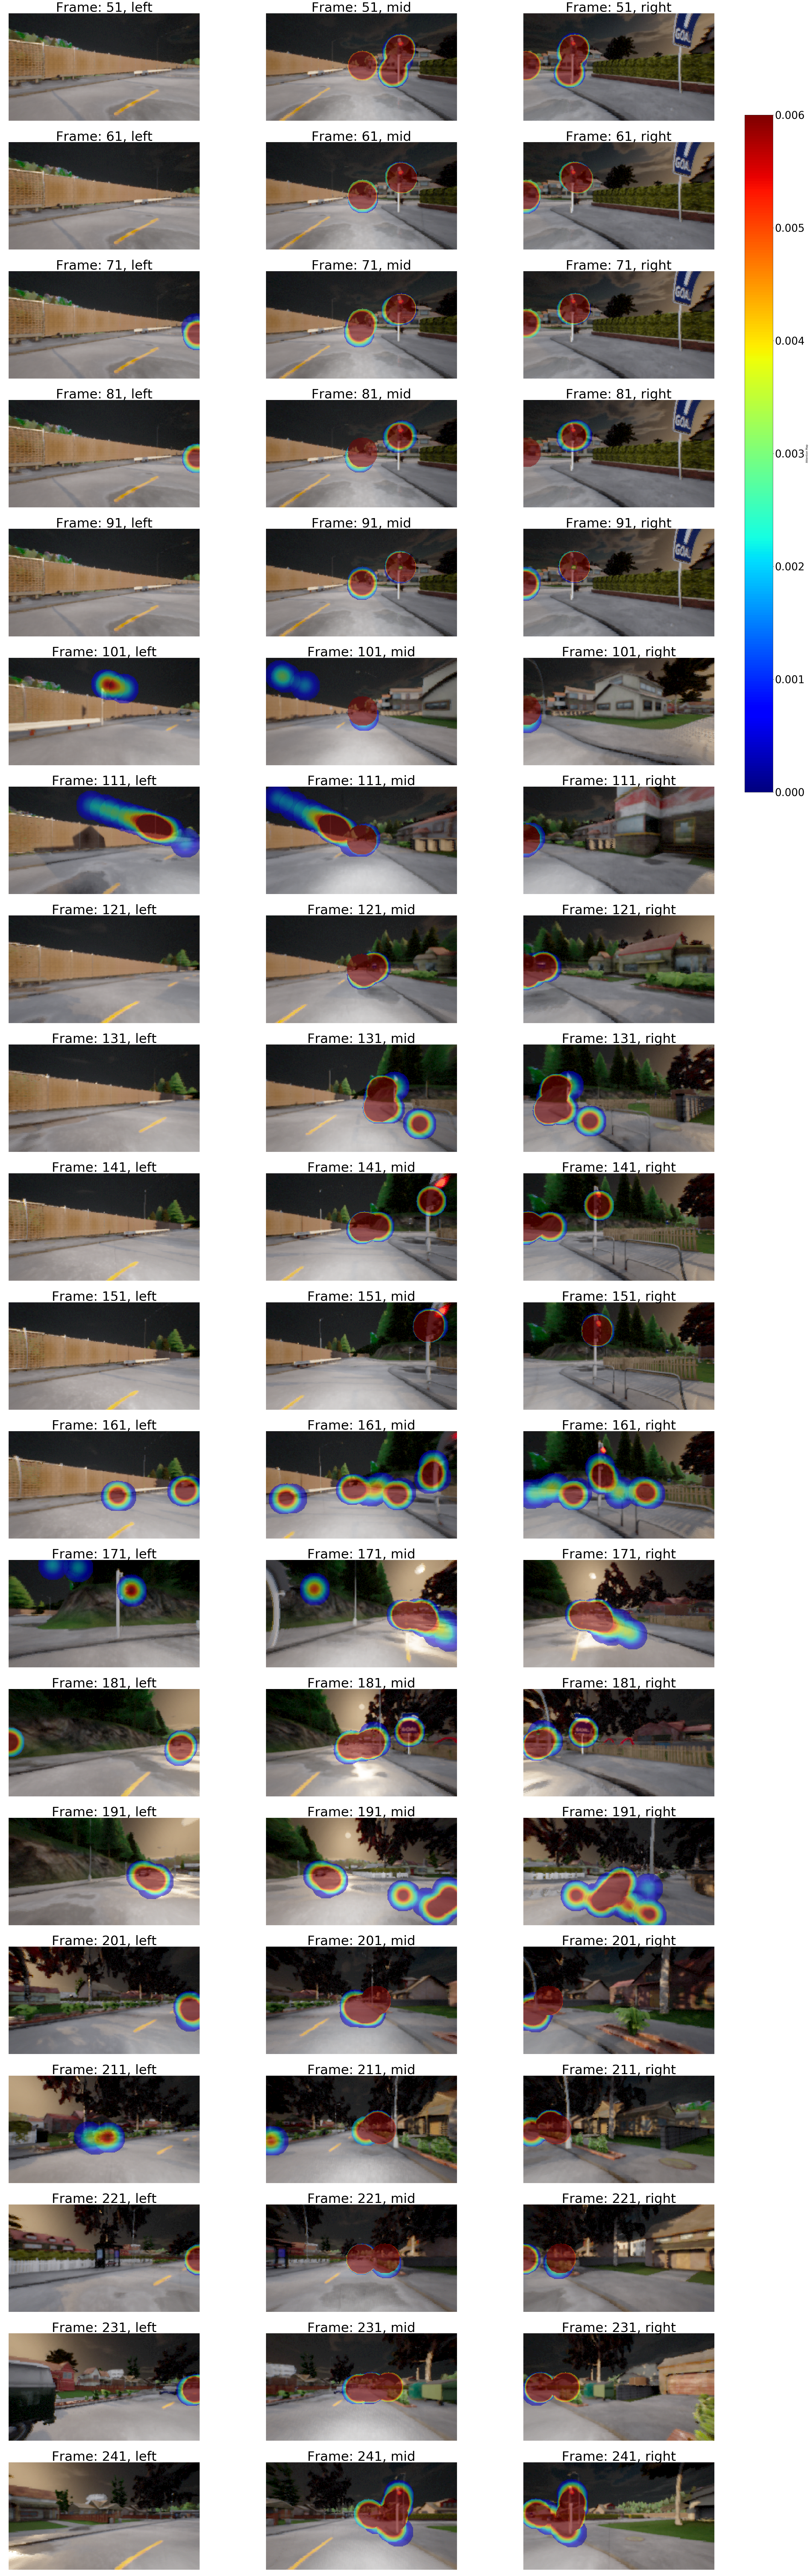

In [11]:
'''
0: exp_brady32 
1: exp_dexter32 
2: exp_tab11 
3: exp_dexter11 
4: exp_tab54 
5: exp_brady11 
6: exp_swapnil32 
7: exp_swapnil54 
8: exp_brady54 
9: exp_esther54 
10: exp_jacob54 
11: exp_esther11 
12: exp_alex54 
13: exp_dexter54 
14: exp_tab32 
15: exp_swapnil11 
16: exp_esther3
'''
%matplotlib inline
debugAttentionMapOverlay(radius = 20, 
                                            sigma = 2, 
                                            threshold=0.003, 
                                            threshold2 = 0.003, 
                                            dataPathIdx=2)

In [13]:
import torch

x = torch.ones(10, 10)
xL = torch.ones(10, 10) * 2
xR = torch.ones(10, 10) * 3
x = x.reshape(1, 10, 10)
xL = xL.reshape(1, 10, 10)
xR = xR.reshape(1, 10, 10)
x_rgb = torch.cat((x, x, x), dim=0)
x_left = torch.cat((xL, xL, xL), dim=0)
x_right = torch.cat((xR, xR, xR), dim=0)
x_stack = torch.cat((x_rgb, x_left, x_right), dim=0)
print(x.shape)
print(x_rgb.shape)
print(x_stack.shape)
print(x_stack[0].shape)

y = x_stack.reshape(3, 3, 10, 10)
print(y.shape)
y = y.sum(dim = 1)
print(y.shape)


torch.Size([1, 10, 10])
torch.Size([3, 10, 10])
torch.Size([9, 10, 10])
torch.Size([10, 10])
torch.Size([3, 3, 10, 10])
torch.Size([3, 10, 10])
